# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: Batch training in action
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [9]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [10]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

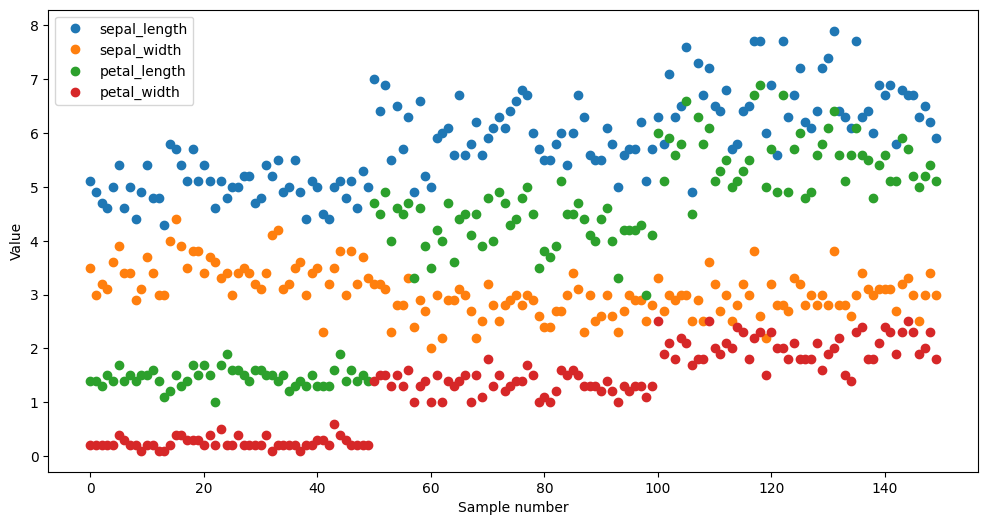

In [11]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [12]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [13]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# Construct the model and training plans

In [14]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=0.001)

  return ANNiris,lossfun,optimizer

In [ ]:
# train the model

# global parameter
numepochs = 500

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    ANNiris.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader))

    # activate testing mode
    ANNiris.eval()
    with torch.no_grad():
      predlabels = torch.argmax( ANNiris(X),axis=1 )

    # compute accuracy
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses


# Test it out

In [23]:

batchsize    = [2,4,8,16,32,64,128]
accuracyResultsTrain = np.zeros((numepochs,len(batchsize)))
accuracyResultsTest  = np.zeros((numepochs,len(batchsize)))

test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

for id,batch in enumerate(batchsize):

  ANNiris,lossfun,optimizer = createANewModel()

  train_loader = DataLoader(train_data,batch_size=batch,shuffle=True,drop_last=True)

  trainAcc,testAcc,losses = trainTheModel()
  accuracyResultsTrain[:,id] = trainAcc
  accuracyResultsTest[:,id]  = testAcc



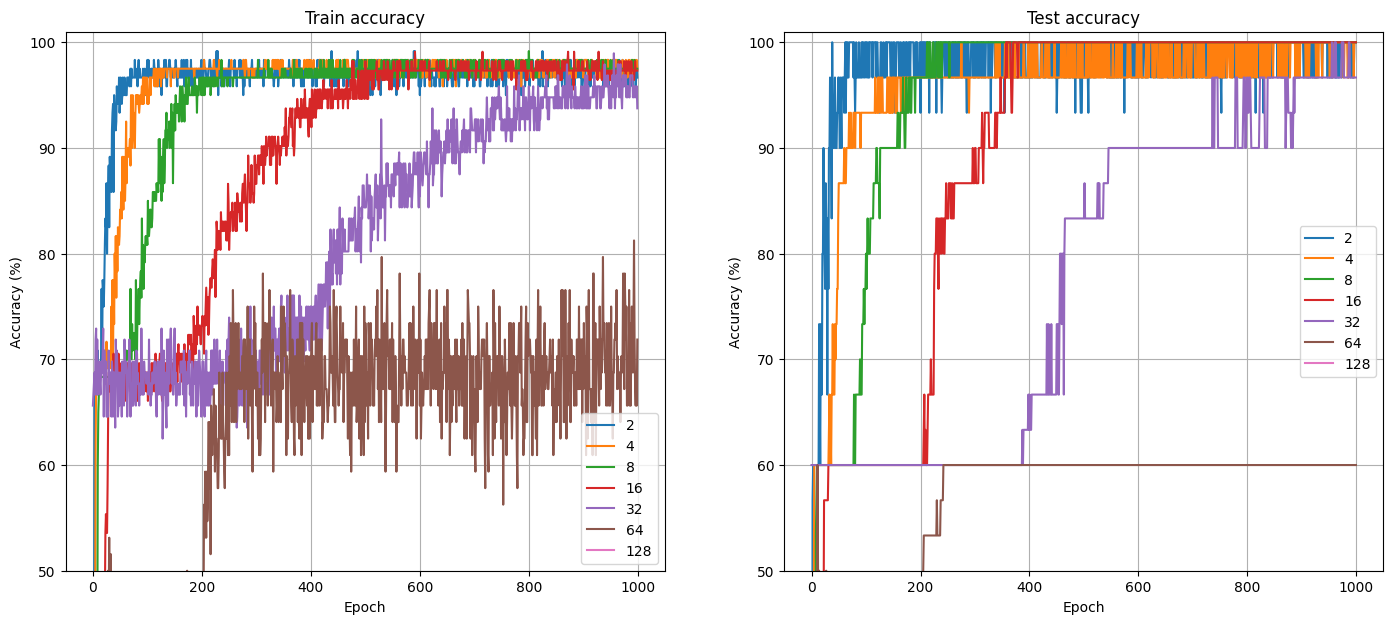

In [25]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(batchsize)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()